In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root = './data',train = True, transform = transform,download = True)
data_loader  = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64,shuffle =True)
test_data = datasets.MNIST(root = './data',train = False, transform = transform,download = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 64,shuffle  = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 279342833.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31366052.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 94125776.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14259377.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data_iter = iter(data_loader)
images, labels  = next(data_iter)
print(torch.min(images),torch.max(images))

tensor(0.) tensor(1.)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,bottleneck = 64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride = 2, padding = 1), # 16 channels 14 * 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1), # 32 channels 7 * 7
            nn.ReLU(),
            nn.Conv2d(32, bottleneck, 7)                                         # 64 channels 1 * 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(bottleneck, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16,kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size = 3, stride  = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def add_gaussian_noise(image_tensor,stddev=0.4):
    noise = torch.randn_like(image_tensor) * stddev
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

In [ ]:
orig_imgs = [img for (img,_) in data_loader]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

def train(orig_imgs,sigma=0.4,bottleneck=64):
    noisy_images_list=[]
    for images in orig_imgs:
        noisy_images = add_gaussian_noise(images,stddev = sigma)
        noisy_images_list.append(noisy_images)
    model = Autoencoder(bottleneck).to(device)
    noisy_images_list = [torch.tensor(noisy_img, device=device) for noisy_img in noisy_images_list]
    orig_imgs = [torch.tensor(orig_img, device=device) for orig_img in orig_imgs]

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 10
    # outputs = []

    for epoch in tqdm(range(num_epochs)):
        for noisy_img, orig_img in zip(noisy_images_list, orig_imgs):
            reconstructed = model(noisy_img)
            loss = criterion(reconstructed, orig_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # if(epoch == 9):
            #     outputs.append((orig_img, reconstructed))
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    return model

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
# SSIM calculation function
def calculate_ssim(image1, image2):
    image1 = image1.cpu().numpy().astype(np.float32)
    image2 = image2.cpu().numpy().astype(np.float32)
    ssim_sum = 0
    # print(image1.shape)
    for i in range(image1.shape[0]):
        ssim_sum += ssim(image1[i, 0], image2[i, 0], data_range=1)
    return ssim_sum / (image1.shape[0])

In [ ]:
def test_model(model, test_loader,sigma=0.4):
    model.eval()
    total_ssim = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)  # Move images to GPU
            noisy_images = add_gaussian_noise(images, stddev = sigma)
            outputs = model(noisy_images)
            total_ssim += calculate_ssim(outputs, images)
    return total_ssim / len(test_loader)

In [ ]:
sigmas = [0.1,0.4,0.8]
ssim_scores=[]
for sigma in sigmas:
    model = train(orig_imgs,sigma)

    model = model.to(device)

    ssim_score = test_model(model, test_loader,sigma)
    print(f'Average SSIM score: {ssim_score:.4f}')
    ssim_scores.append(ssim_score)

<ipython-input-17-2d6d6a589845>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images_list = [torch.tensor(noisy_img, device=device) for noisy_img in noisy_images_list]
<ipython-input-17-2d6d6a589845>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_imgs = [torch.tensor(orig_img, device=device) for orig_img in orig_imgs]
 10%|█         | 1/10 [00:36<05:30, 36.69s/it]

Epoch:1, Loss:0.0126


 20%|██        | 2/10 [01:08<04:30, 33.77s/it]

Epoch:2, Loss:0.0069


 30%|███       | 3/10 [01:41<03:53, 33.43s/it]

Epoch:3, Loss:0.0054


 40%|████      | 4/10 [02:13<03:17, 32.99s/it]

Epoch:4, Loss:0.0046


 50%|█████     | 5/10 [02:47<02:46, 33.27s/it]

Epoch:5, Loss:0.0042


 60%|██████    | 6/10 [03:20<02:12, 33.22s/it]

Epoch:6, Loss:0.0039


 70%|███████   | 7/10 [03:54<01:40, 33.34s/it]

Epoch:7, Loss:0.0037


 80%|████████  | 8/10 [04:26<01:06, 33.13s/it]

Epoch:8, Loss:0.0035


 90%|█████████ | 9/10 [04:59<00:33, 33.03s/it]

Epoch:9, Loss:0.0033


100%|██████████| 10/10 [05:32<00:00, 33.25s/it]

Epoch:10, Loss:0.0032
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)


(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 

 10%|█         | 1/10 [00:31<04:42, 31.35s/it]

Epoch:1, Loss:0.0192


 20%|██        | 2/10 [01:03<04:15, 31.97s/it]

Epoch:2, Loss:0.0132


 30%|███       | 3/10 [01:35<03:43, 31.90s/it]

Epoch:3, Loss:0.0112


 40%|████      | 4/10 [02:08<03:13, 32.18s/it]

Epoch:4, Loss:0.0102


 50%|█████     | 5/10 [02:39<02:40, 32.04s/it]

Epoch:5, Loss:0.0097


 60%|██████    | 6/10 [03:13<02:09, 32.50s/it]

Epoch:6, Loss:0.0093


 70%|███████   | 7/10 [03:45<01:37, 32.34s/it]

Epoch:7, Loss:0.0089


 80%|████████  | 8/10 [04:17<01:04, 32.13s/it]

Epoch:8, Loss:0.0086


 90%|█████████ | 9/10 [04:49<00:32, 32.28s/it]

Epoch:9, Loss:0.0084


100%|██████████| 10/10 [05:21<00:00, 32.16s/it]

Epoch:10, Loss:0.0082
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)


(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 

 10%|█         | 1/10 [00:31<04:41, 31.23s/it]

Epoch:1, Loss:0.0327


 20%|██        | 2/10 [01:03<04:12, 31.61s/it]

Epoch:2, Loss:0.0257


 30%|███       | 3/10 [01:34<03:40, 31.45s/it]

Epoch:3, Loss:0.0237


 40%|████      | 4/10 [02:07<03:12, 32.12s/it]

Epoch:4, Loss:0.0228


 50%|█████     | 5/10 [02:39<02:40, 32.16s/it]

Epoch:5, Loss:0.0220


 60%|██████    | 6/10 [03:12<02:09, 32.29s/it]

Epoch:6, Loss:0.0215


 70%|███████   | 7/10 [03:47<01:40, 33.38s/it]

Epoch:7, Loss:0.0211


 80%|████████  | 8/10 [04:22<01:07, 33.74s/it]

Epoch:8, Loss:0.0208


 90%|█████████ | 9/10 [04:55<00:33, 33.54s/it]

Epoch:9, Loss:0.0205


100%|██████████| 10/10 [05:29<00:00, 32.96s/it]

Epoch:10, Loss:0.0201
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)


(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 28, 28)
(64, 1, 

Text(0, 0.5, 'Average SSIM Score')

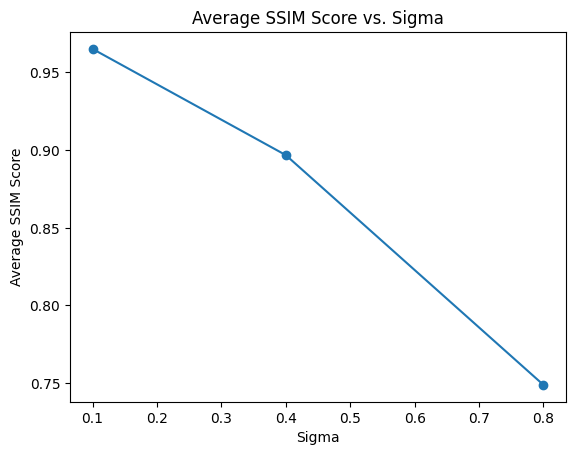

In [ ]:
plt.plot(sigmas, ssim_scores, marker='o')
plt.title('Average SSIM Score vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Score')

# Observations and Analysis:
* With the increase of sigma value the similarity between two images got reduced.
* It suggests that higher levels of blurring introduce more distortion and high frequency information loss which is required for image reconstruction.Inturn it reduces the similarity.

In [ ]:
bottlenecks = [32,48,64]
ssim_scores=[]
for bottleneck in bottlenecks:
    model = train(orig_imgs,bottleneck = bottleneck)

    model = model.to(device)

    ssim_score = test_model(model, test_loader)
    print(f'Average SSIM score: {ssim_score:.4f}')
    ssim_scores.append(ssim_score)

<ipython-input-7-2078f80d7c73>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_images_list = [torch.tensor(noisy_img, device=device) for noisy_img in noisy_images_list]
<ipython-input-7-2078f80d7c73>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_imgs = [torch.tensor(orig_img, device=device) for orig_img in orig_imgs]
 10%|█         | 1/10 [00:21<03:10, 21.20s/it]

Epoch:1, Loss:0.0167


 20%|██        | 2/10 [00:42<02:48, 21.11s/it]

Epoch:2, Loss:0.0121


 30%|███       | 3/10 [01:02<02:25, 20.85s/it]

Epoch:3, Loss:0.0109


 40%|████      | 4/10 [01:24<02:07, 21.18s/it]

Epoch:4, Loss:0.0101


 50%|█████     | 5/10 [01:45<01:46, 21.26s/it]

Epoch:5, Loss:0.0097


 60%|██████    | 6/10 [02:06<01:24, 21.09s/it]

Epoch:6, Loss:0.0095


 70%|███████   | 7/10 [02:26<01:02, 20.85s/it]

Epoch:7, Loss:0.0093


 80%|████████  | 8/10 [02:47<00:41, 20.86s/it]

Epoch:8, Loss:0.0092


 90%|█████████ | 9/10 [03:08<00:20, 20.88s/it]

Epoch:9, Loss:0.0091


100%|██████████| 10/10 [03:29<00:00, 20.92s/it]

Epoch:10, Loss:0.0089


Average SSIM score: 0.8871


 10%|█         | 1/10 [00:22<03:25, 22.80s/it]

Epoch:1, Loss:0.0171


 20%|██        | 2/10 [00:44<02:59, 22.40s/it]

Epoch:2, Loss:0.0117


 30%|███       | 3/10 [01:08<02:39, 22.74s/it]

Epoch:3, Loss:0.0101


 40%|████      | 4/10 [01:31<02:18, 23.05s/it]

Epoch:4, Loss:0.0094


 50%|█████     | 5/10 [01:54<01:55, 23.00s/it]

Epoch:5, Loss:0.0088


 60%|██████    | 6/10 [02:17<01:32, 23.08s/it]

Epoch:6, Loss:0.0085


 70%|███████   | 7/10 [02:40<01:09, 23.13s/it]

Epoch:7, Loss:0.0082


 80%|████████  | 8/10 [03:04<00:46, 23.19s/it]

Epoch:8, Loss:0.0080


 90%|█████████ | 9/10 [03:27<00:23, 23.27s/it]

Epoch:9, Loss:0.0078


100%|██████████| 10/10 [03:50<00:00, 23.06s/it]

Epoch:10, Loss:0.0077


Average SSIM score: 0.8907


 10%|█         | 1/10 [00:23<03:35, 24.00s/it]

Epoch:1, Loss:0.0197


 20%|██        | 2/10 [00:48<03:15, 24.40s/it]

Epoch:2, Loss:0.0126


 30%|███       | 3/10 [01:13<02:53, 24.75s/it]

Epoch:3, Loss:0.0110


 40%|████      | 4/10 [01:39<02:30, 25.12s/it]

Epoch:4, Loss:0.0101


 50%|█████     | 5/10 [02:04<02:05, 25.00s/it]

Epoch:5, Loss:0.0095


 60%|██████    | 6/10 [02:29<01:40, 25.13s/it]

Epoch:6, Loss:0.0092


 70%|███████   | 7/10 [02:55<01:15, 25.22s/it]

Epoch:7, Loss:0.0090


 80%|████████  | 8/10 [03:20<00:50, 25.42s/it]

Epoch:8, Loss:0.0088


 90%|█████████ | 9/10 [03:46<00:25, 25.37s/it]

Epoch:9, Loss:0.0086


100%|██████████| 10/10 [04:11<00:00, 25.12s/it]

Epoch:10, Loss:0.0084


Average SSIM score: 0.8945


Text(0, 0.5, 'Average SSIM Score')

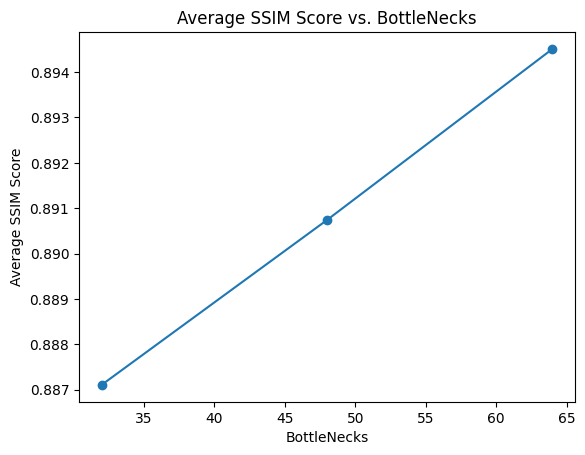

In [ ]:
plt.plot(bottlenecks, ssim_scores, marker='o')
plt.title('Average SSIM Score vs. BottleNecks')
plt.xlabel('BottleNecks')
plt.ylabel('Average SSIM Score')

# Observation and analysis:
* With the increase bottleneck layer size the ssim score got increased.
*  A larger bottleneck layer allowed the model to capture and preserve more information about the original image during the encoding phase. This increased capacity enabled the model to retain crucial details and structural information that might have been lost during blurring.